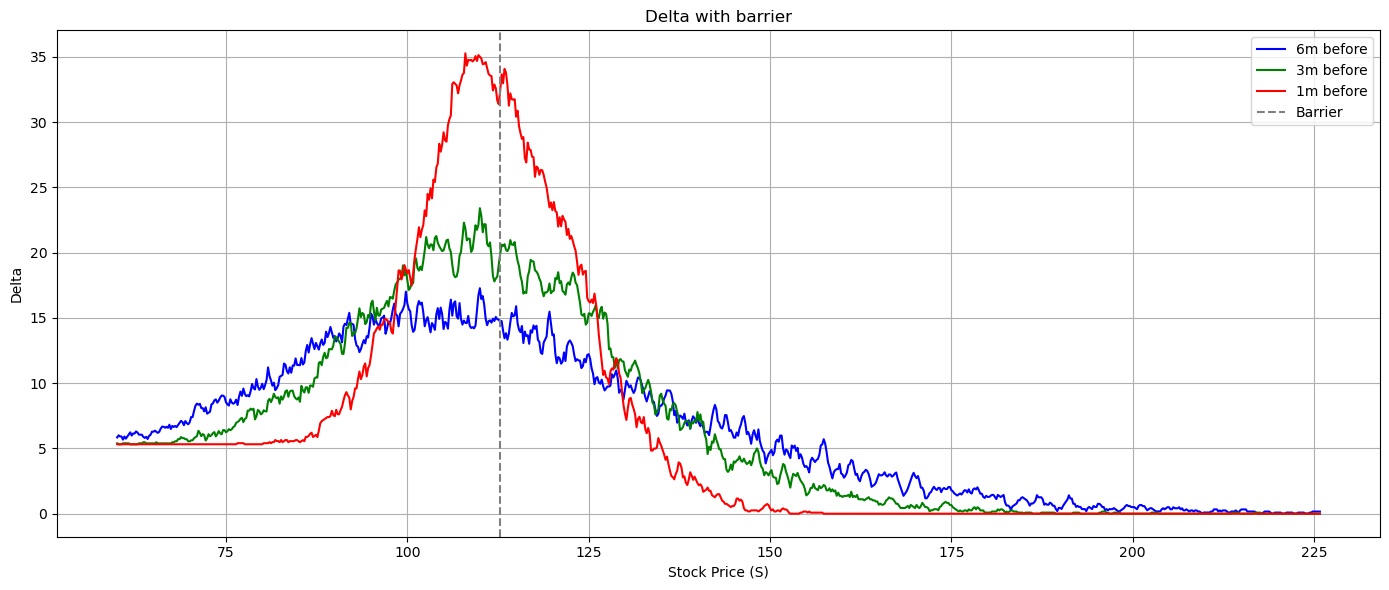

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters ---
S0 = 187.98
r = 0.022752
sigma = 0.27772
n_paths = 10000
finite_diff = 0.5
nominal = 1000
coupon = 70
total_coupon = 6 * coupon
early_redemption_levels = [1.00, 0.95, 0.90, 0.85, 0.80]
observation_days = [252 * i for i in range(1, 6)]
barrier = 0.6 * S0

# --- Pricing function ---
def price_certificate(S_t, r, sigma, T, S0, n_paths=10000):
    N = int(252 * T)
    dt = T / N
    Z = np.random.standard_normal((n_paths, N))
    paths = np.zeros_like(Z)
    paths[:, 0] = S_t
    for t in range(1, N):
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])
    payoffs = []
    for i in range(n_paths):
        path = paths[i]
        redeemed = False
        for j, obs_day in enumerate(observation_days):
            if obs_day < len(path) and path[obs_day] >= early_redemption_levels[j] * S0:
                payoffs.append(np.exp(-r * (obs_day / 252)) * (nominal + (j + 1) * coupon))
                redeemed = True
                break
        if not redeemed:
            S_end = path[-1]
            val = nominal + total_coupon if S_end >= barrier else nominal * (S_end / S0)
            payoffs.append(np.exp(-r * T) * val)
    return np.mean(payoffs)

# --- Delta function ---
def compute_delta(S, r, sigma, T, S0, h=0.5):
    np.random.seed(42)  # reset each time to same paths
    V_plus = price_certificate(S + h, r, sigma, T, S0, n_paths)
    np.random.seed(42)
    V_minus = price_certificate(S - h, r, sigma, T, S0, n_paths)
    return (V_plus - V_minus) / (2 * h)

# --- Setup ---
price_range = np.arange(60, 226, 0.2)
next_redemption_date = pd.to_datetime("2025-05-17")
test_dates = [
    next_redemption_date - pd.DateOffset(months=6),
    next_redemption_date - pd.DateOffset(months=3),
    next_redemption_date - pd.DateOffset(months=1),
]
today = pd.to_datetime("2024-05-17")


# --- Delta Matrix ---
delta_matrix = pd.DataFrame(index=price_range, columns=["6m before", "3m before", "1m before"])

for idx, test_date in enumerate(test_dates):
    T_remaining = (next_redemption_date - test_date).days / 252
    deltas = []
    for S in price_range:
        d = compute_delta(S, r, sigma, T_remaining, S0, finite_diff)
        deltas.append(d)
    delta_matrix[delta_matrix.columns[idx]] = deltas

# --- Plot ---
plt.figure(figsize=(14, 6))
colors = ['blue', 'green', 'red']
for i, col in enumerate(delta_matrix.columns):
    plt.plot(price_range, delta_matrix[col], label=f"{col}", color=colors[i])
plt.axvline(0.6 * S0, linestyle='--', color='gray', label="Barrier")
plt.title("Delta with barrier")
plt.xlabel("Stock Price (S)")
plt.ylabel("Delta")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

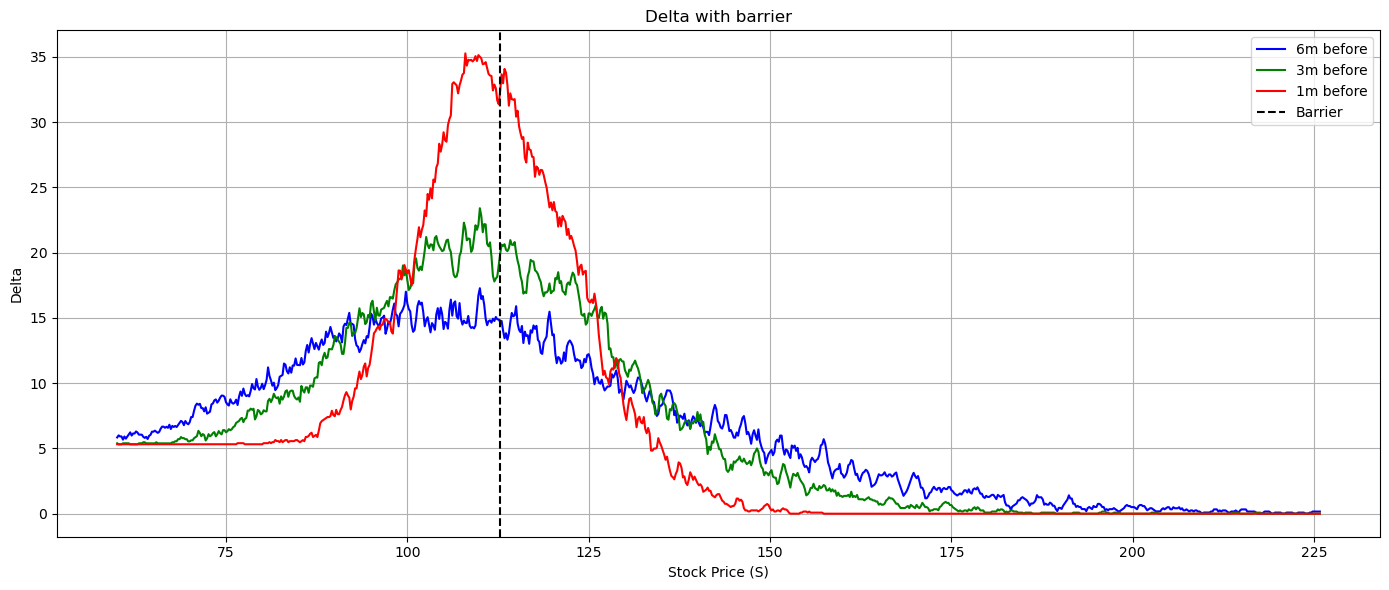

In [2]:
plt.figure(figsize=(14, 6))
colors = ['blue', 'green', 'red']
for i, col in enumerate(delta_matrix.columns):
    plt.plot(price_range, delta_matrix[col], label=f"{col}", color=colors[i])
plt.axvline(0.6 * S0, linestyle='--', color='black', label="Barrier")
plt.title("Delta with barrier")
plt.xlabel("Stock Price (S)")
plt.ylabel("Delta")
plt.grid(True)
plt.legend()
plt.tight_layout()
#plt.savefig("delta_plot.pdf", dpi=300)  # or use dpi=600 for print-quality
plt.show()



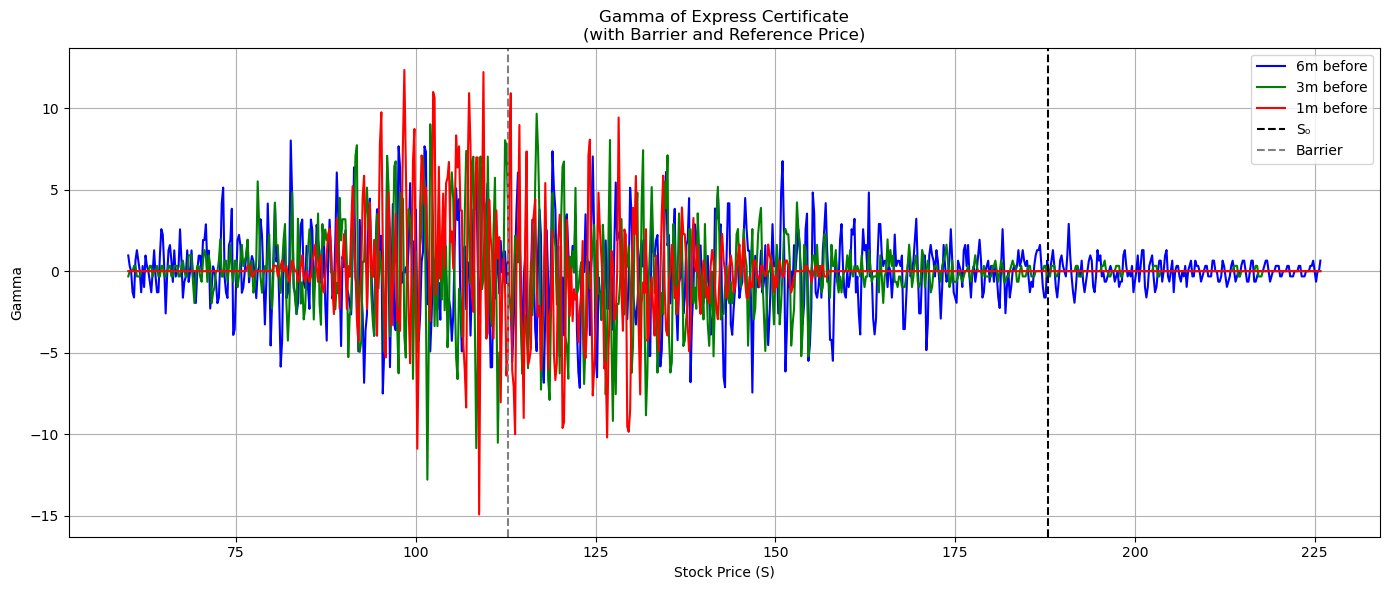

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters ---
S0 = 187.98
r = 0.022752
sigma = 0.27772
n_paths = 10000
finite_diff = 0.5
nominal = 1000
coupon = 70
total_coupon = 6 * coupon
early_redemption_levels = [1.00, 0.95, 0.90, 0.85, 0.80]
observation_days = [252 * i for i in range(1, 6)]
barrier = 0.6 * S0

# --- Pricing function ---
def price_certificate(S_t, r, sigma, T, S0, n_paths=10000):
    N = int(252 * T)
    dt = T / N
    Z = np.random.standard_normal((n_paths, N))
    paths = np.zeros_like(Z)
    paths[:, 0] = S_t
    for t in range(1, N):
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])
    payoffs = []
    for i in range(n_paths):
        path = paths[i]
        redeemed = False
        for j, obs_day in enumerate(observation_days):
            if obs_day < len(path) and path[obs_day] >= early_redemption_levels[j] * S0:
                payoffs.append(np.exp(-r * (obs_day / 252)) * (nominal + (j + 1) * coupon))
                redeemed = True
                break
        if not redeemed:
            S_end = path[-1]
            val = nominal + total_coupon if S_end >= barrier else nominal * (S_end / S0)
            payoffs.append(np.exp(-r * T) * val)
    return np.mean(payoffs)

# --- Gamma function ---
def compute_gamma(S, r, sigma, T, S0, h=0.5):
    np.random.seed(42)
    V_plus = price_certificate(S + h, r, sigma, T, S0, n_paths)
    np.random.seed(42)
    V_0 = price_certificate(S, r, sigma, T, S0, n_paths)
    np.random.seed(42)
    V_minus = price_certificate(S - h, r, sigma, T, S0, n_paths)
    return (V_plus - 2 * V_0 + V_minus) / (h ** 2)

# --- Setup ---
price_range = np.arange(60, 226, 0.2)
next_redemption_date = pd.to_datetime("2025-05-17")
test_dates = [
    next_redemption_date - pd.DateOffset(months=6),
    next_redemption_date - pd.DateOffset(months=3),
    next_redemption_date - pd.DateOffset(months=1),
]

# --- Gamma Matrix ---
gamma_matrix = pd.DataFrame(index=price_range, columns=["6m before", "3m before", "1m before"])

for idx, test_date in enumerate(test_dates):
    T_remaining = (next_redemption_date - test_date).days / 252
    gammas = []
    for S in price_range:
        gamma = compute_gamma(S, r, sigma, T_remaining, S0, finite_diff)
        gammas.append(gamma)
    gamma_matrix[gamma_matrix.columns[idx]] = gammas

# --- Plot ---
plt.figure(figsize=(14, 6))
colors = ['blue', 'green', 'red']
for i, col in enumerate(gamma_matrix.columns):
    plt.plot(price_range, gamma_matrix[col], label=col, color=colors[i])
plt.axvline(S0, linestyle='--', color='black', label="S₀")
plt.axvline(0.6 * S0, linestyle='--', color='gray', label="Barrier")
plt.title("Gamma of Express Certificate\n(with Barrier and Reference Price)")
plt.xlabel("Stock Price (S)")
plt.ylabel("Gamma")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

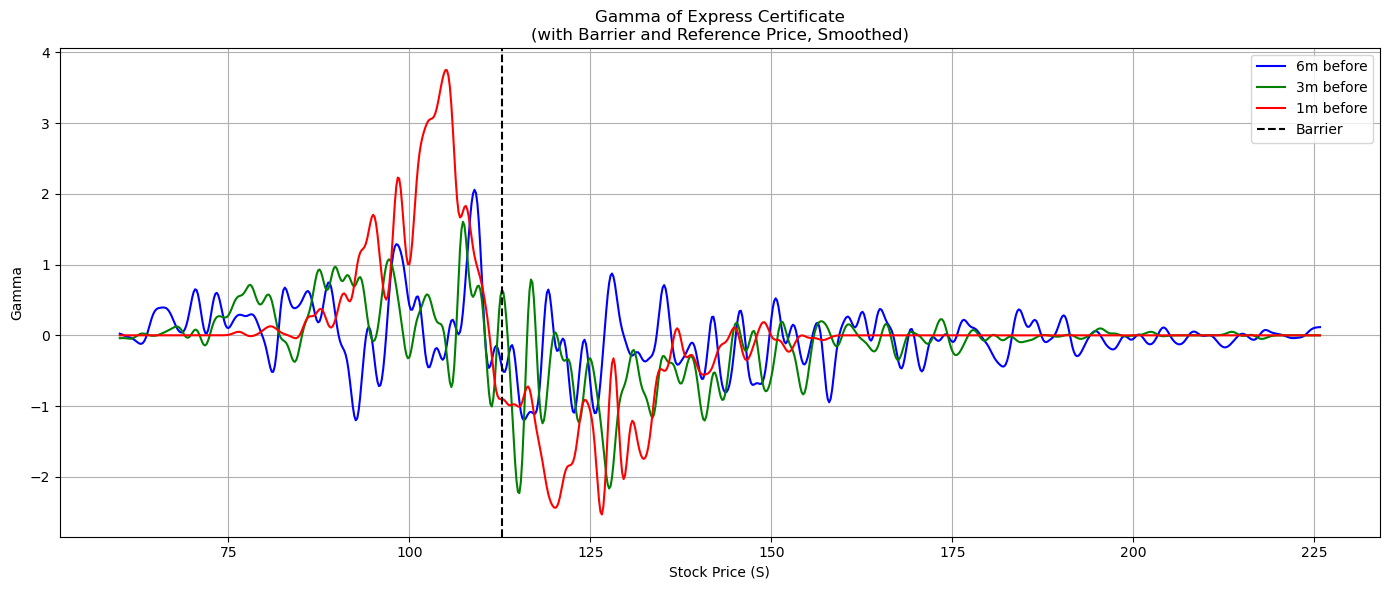

In [4]:
from scipy.ndimage import gaussian_filter1d

# --- Smooth Gamma Matrix using Gaussian filter ---
smoothed_gamma = gamma_matrix.copy()
for col in gamma_matrix.columns:
    smoothed_gamma[col] = gaussian_filter1d(gamma_matrix[col].values, sigma=4)

# --- Plot ---
plt.figure(figsize=(14, 6))
colors = ['blue', 'green', 'red']
for i, col in enumerate(smoothed_gamma.columns):
    plt.plot(price_range, smoothed_gamma[col], label=col, color=colors[i])

plt.axvline(0.6 * S0, linestyle='--', color='black', label="Barrier")
plt.title("Gamma of Express Certificate\n(with Barrier and Reference Price, Smoothed)")
plt.xlabel("Stock Price (S)")
plt.ylabel("Gamma")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

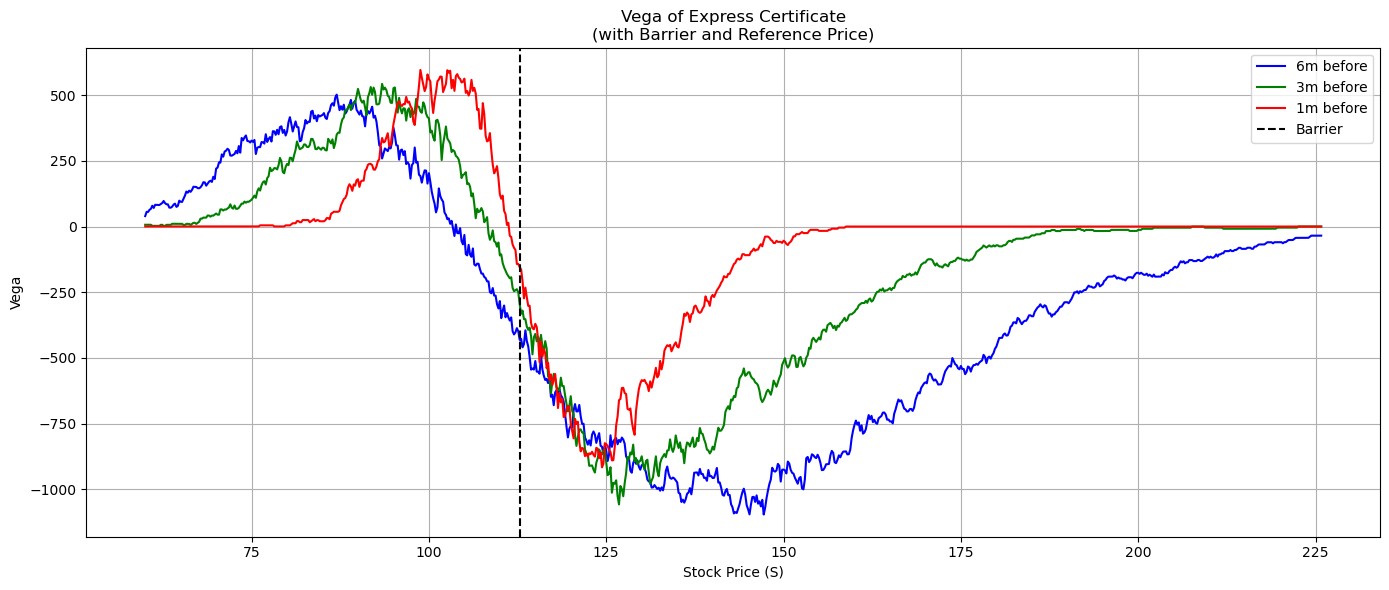

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters ---
S0 = 187.98
r = 0.022752
sigma = 0.27772
n_paths = 10000
finite_diff_vol = 0.01
nominal = 1000
coupon = 70
total_coupon = 6 * coupon
early_redemption_levels = [1.00, 0.95, 0.90, 0.85, 0.80]
observation_days = [252 * i for i in range(1, 6)]
barrier = 0.6 * S0

def price_certificate(S_t, r, sigma, T, S0, n_paths=10000):
    N = int(252 * T)
    dt = T / N
    Z = np.random.standard_normal((n_paths, N))
    paths = np.zeros_like(Z)
    paths[:, 0] = S_t
    for t in range(1, N):
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])
    payoffs = []
    for i in range(n_paths):
        path = paths[i]
        redeemed = False
        for j, obs_day in enumerate(observation_days):
            if obs_day < len(path) and path[obs_day] >= early_redemption_levels[j] * S0:
                payoffs.append(np.exp(-r * (obs_day / 252)) * (nominal + (j + 1) * coupon))
                redeemed = True
                break
        if not redeemed:
            S_end = path[-1]
            val = nominal + total_coupon if S_end >= barrier else nominal * (S_end / S0)
            payoffs.append(np.exp(-r * T) * val)
    return np.mean(payoffs)

def compute_vega(S, r, sigma, T, S0, h=0.01):
    np.random.seed(42)
    V_plus = price_certificate(S, r, sigma + h, T, S0, n_paths)
    np.random.seed(42)
    V_minus = price_certificate(S, r, sigma - h, T, S0, n_paths)
    return (V_plus - V_minus) / (2 * h)

price_range = np.arange(60, 226, 0.2)
next_redemption_date = pd.to_datetime("2025-05-17")
test_dates = [
    next_redemption_date - pd.DateOffset(months=6),
    next_redemption_date - pd.DateOffset(months=3),
    next_redemption_date - pd.DateOffset(months=1),
]

vega_matrix = pd.DataFrame(index=price_range, columns=["6m before", "3m before", "1m before"])

for idx, test_date in enumerate(test_dates):
    T_remaining = (next_redemption_date - test_date).days / 252
    vegas = []
    for S in price_range:
        v = compute_vega(S, r, sigma, T_remaining, S0, finite_diff_vol)
        vegas.append(v)
    vega_matrix[vega_matrix.columns[idx]] = vegas

plt.figure(figsize=(14, 6))
colors = ['blue', 'green', 'red']
for i, col in enumerate(vega_matrix.columns):
    plt.plot(price_range, vega_matrix[col], label=col, color=colors[i])

plt.axvline(0.6 * S0, linestyle='--', color='black', label="Barrier")
plt.title("Vega of Express Certificate\n(with Barrier and Reference Price)")
plt.xlabel("Stock Price (S)")
plt.ylabel("Vega")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

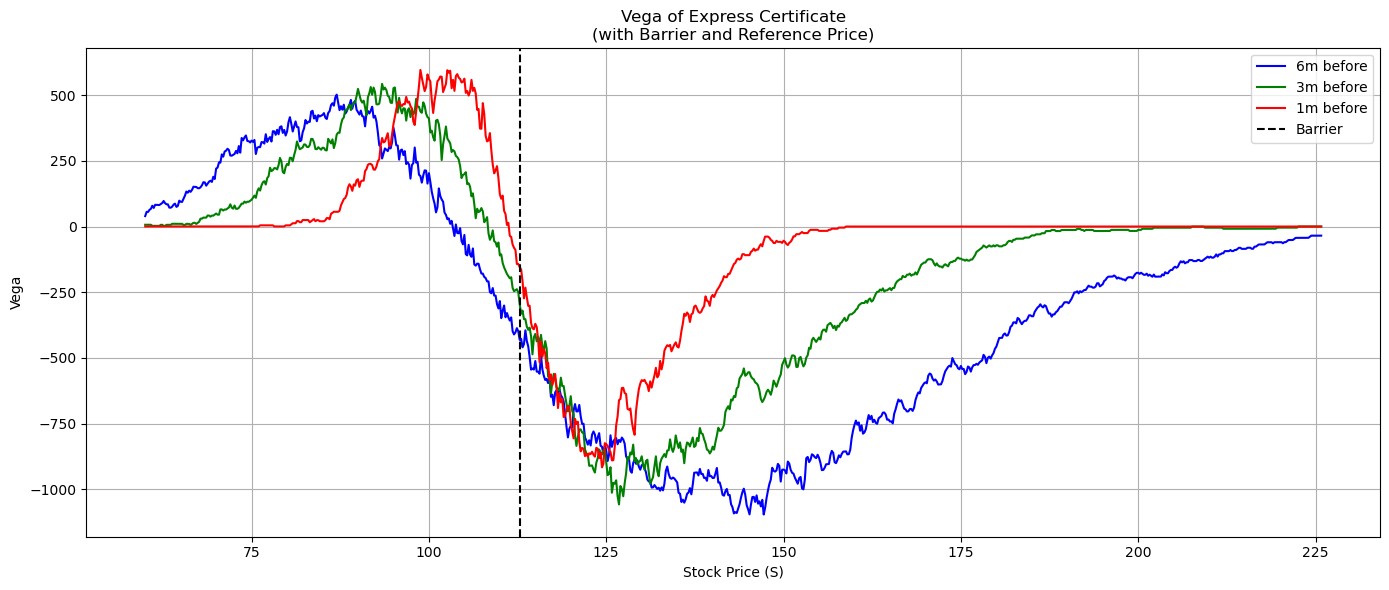

In [6]:
plt.figure(figsize=(14, 6))
colors = ['blue', 'green', 'red']
for i, col in enumerate(vega_matrix.columns):
    plt.plot(price_range, vega_matrix[col], label=col, color=colors[i])

plt.axvline(0.6 * S0, linestyle='--', color='black', label="Barrier")
plt.title("Vega of Express Certificate\n(with Barrier and Reference Price)")
plt.xlabel("Stock Price (S)")
plt.ylabel("Vega")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

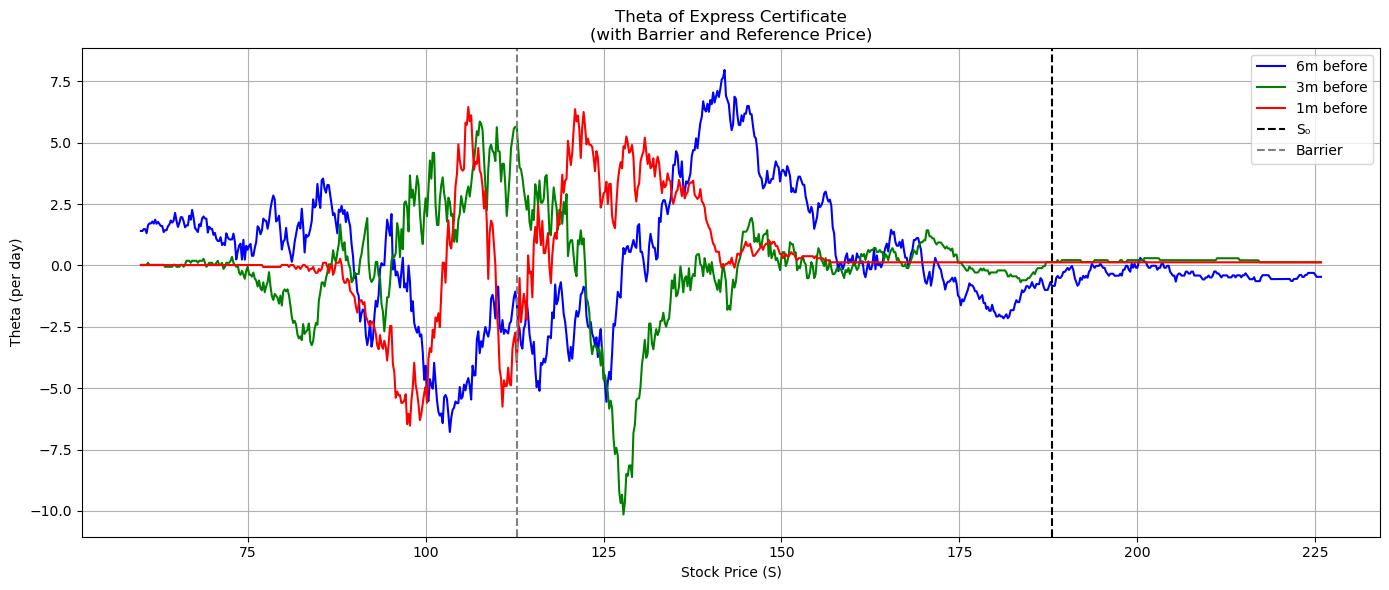

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters ---
S0 = 187.98
r = 0.022752
sigma = 0.27772
n_paths = 10000
finite_diff = 1 / 252  # one trading day
nominal = 1000
coupon = 70
total_coupon = 6 * coupon
early_redemption_levels = [1.00, 0.95, 0.90, 0.85, 0.80]
observation_days = [252 * i for i in range(1, 6)]
barrier = 0.6 * S0

# --- Pricing function ---
def price_certificate(S_t, r, sigma, T, S0, n_paths=10000):
    N = int(252 * T)
    dt = T / N
    Z = np.random.standard_normal((n_paths, N))
    paths = np.zeros_like(Z)
    paths[:, 0] = S_t
    for t in range(1, N):
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])
    payoffs = []
    for i in range(n_paths):
        path = paths[i]
        redeemed = False
        for j, obs_day in enumerate(observation_days):
            if obs_day < len(path) and path[obs_day] >= early_redemption_levels[j] * S0:
                payoffs.append(np.exp(-r * (obs_day / 252)) * (nominal + (j + 1) * coupon))
                redeemed = True
                break
        if not redeemed:
            S_end = path[-1]
            val = nominal + total_coupon if S_end >= barrier else nominal * (S_end / S0)
            payoffs.append(np.exp(-r * T) * val)
    return np.mean(payoffs)

# --- Theta function (per day) ---
def compute_theta(S, r, sigma, T, S0, h=1/252):
    np.random.seed(42)
    V_now = price_certificate(S, r, sigma, T, S0, n_paths)
    np.random.seed(42)
    V_later = price_certificate(S, r, sigma, T - h, S0, n_paths)
    return V_later - V_now  # per day

# --- Setup ---
price_range = np.arange(60, 226, 0.2)
next_redemption_date = pd.to_datetime("2025-05-17")
test_dates = [
    next_redemption_date - pd.DateOffset(months=6),
    next_redemption_date - pd.DateOffset(months=3),
    next_redemption_date - pd.DateOffset(months=1),
]

# --- Theta Matrix ---
theta_matrix = pd.DataFrame(index=price_range, columns=["6m before", "3m before", "1m before"])

for idx, test_date in enumerate(test_dates):
    T_remaining = (next_redemption_date - test_date).days / 252
    thetas = []
    for S in price_range:
        theta = compute_theta(S, r, sigma, T_remaining, S0, finite_diff)
        thetas.append(theta)
    theta_matrix[theta_matrix.columns[idx]] = thetas

# --- Plot ---
plt.figure(figsize=(14, 6))
colors = ['blue', 'green', 'red']
for i, col in enumerate(theta_matrix.columns):
    plt.plot(price_range, theta_matrix[col], label=col, color=colors[i])
plt.axvline(S0, linestyle='--', color='black', label="S₀")
plt.axvline(0.6 * S0, linestyle='--', color='gray', label="Barrier")
plt.title("Theta of Express Certificate\n(with Barrier and Reference Price)")
plt.xlabel("Stock Price (S)")
plt.ylabel("Theta (per day)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

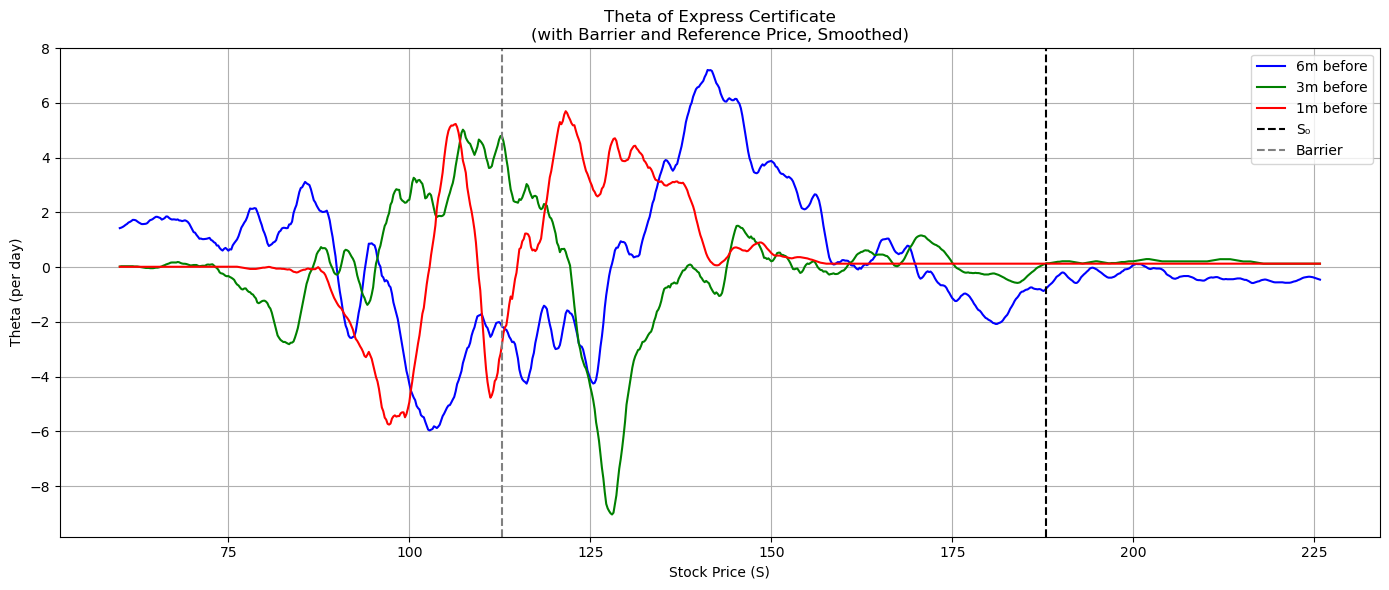

In [8]:
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt

# --- Smooth Theta Matrix ---
smoothed_theta = theta_matrix.copy()
for col in theta_matrix.columns:
    smoothed_theta[col] = uniform_filter1d(theta_matrix[col].values, size=9)

# --- Plot ---
plt.figure(figsize=(14, 6))
colors = ['blue', 'green', 'red']
for i, col in enumerate(smoothed_theta.columns):
    plt.plot(price_range, smoothed_theta[col], label=col, color=colors[i])
plt.axvline(S0, linestyle='--', color='black', label="S₀")
plt.axvline(0.6 * S0, linestyle='--', color='gray', label="Barrier")
plt.title("Theta of Express Certificate\n(with Barrier and Reference Price, Smoothed)")
plt.xlabel("Stock Price (S)")
plt.ylabel("Theta (per day)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

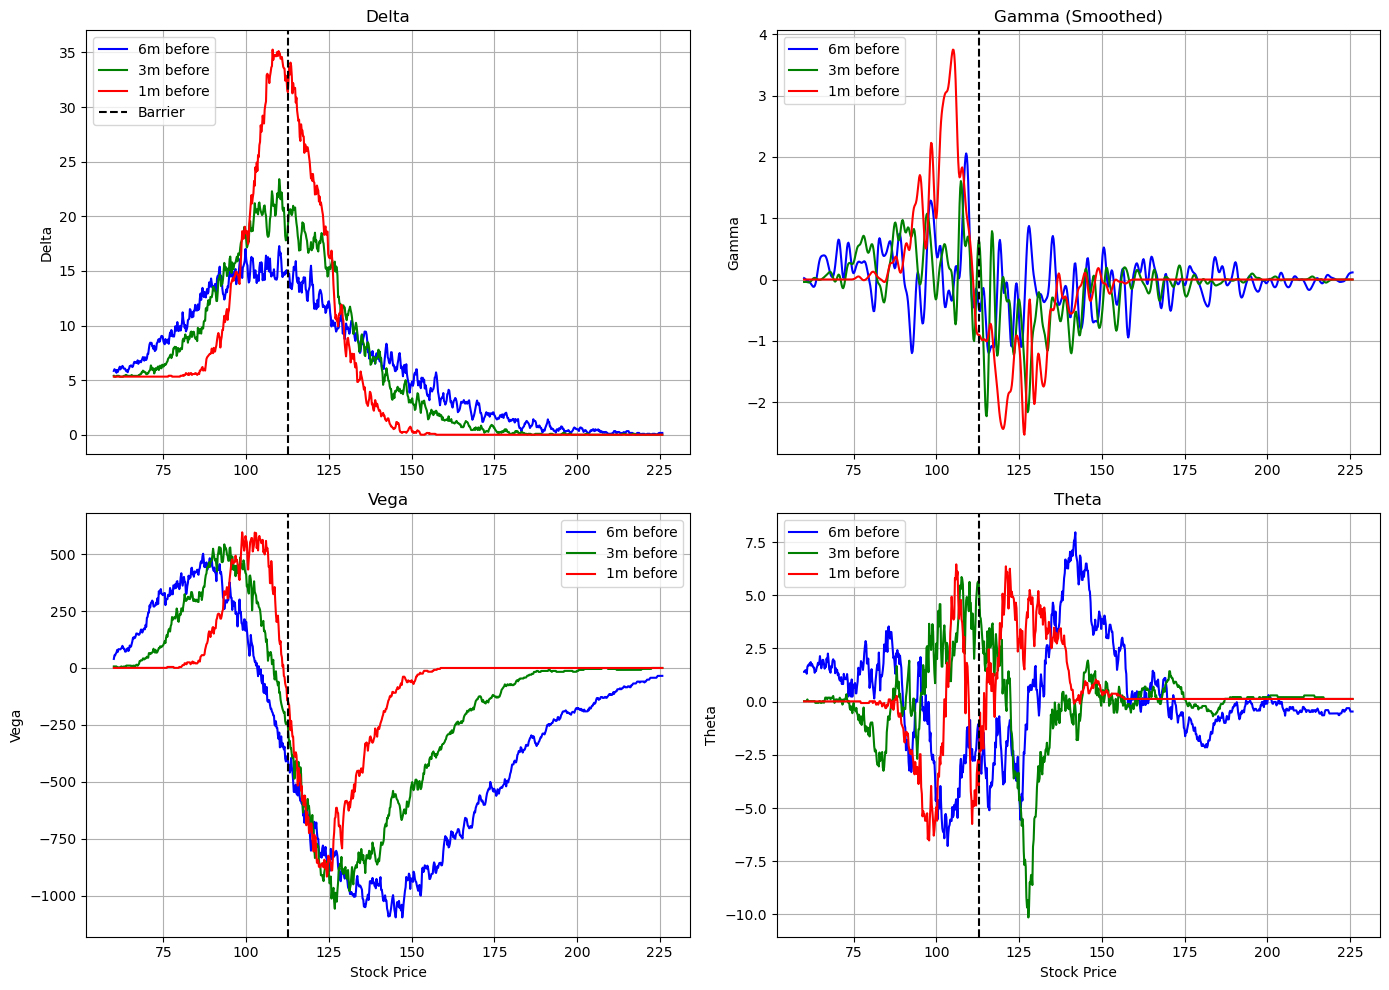

In [9]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# --- Smooth Gamma Matrix ---
smoothed_gamma = gamma_matrix.copy()
for col in gamma_matrix.columns:
    smoothed_gamma[col] = gaussian_filter1d(gamma_matrix[col].values, sigma=4)

# --- Plot Greeks: 2x2 layout ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
colors = ['blue', 'green', 'red']

# --- Delta ---
axs[0, 0].set_title("Delta")
for i, col in enumerate(delta_matrix.columns):
    axs[0, 0].plot(price_range, delta_matrix[col], color=colors[i], label=col)
axs[0, 0].axvline(barrier, linestyle='--', color='black', label="Barrier")
axs[0, 0].set_ylabel("Delta")
axs[0, 0].grid(True)
axs[0, 0].legend(loc='upper left')

# --- Gamma (smoothed) ---
axs[0, 1].set_title("Gamma (Smoothed)")
for i, col in enumerate(smoothed_gamma.columns):
    axs[0, 1].plot(price_range, smoothed_gamma[col], color=colors[i], label=col)
axs[0, 1].axvline(barrier, linestyle='--', color='black')
axs[0, 1].set_ylabel("Gamma")
axs[0, 1].grid(True)
axs[0, 1].legend(loc='upper left')

# --- Vega ---
axs[1, 0].set_title("Vega")
for i, col in enumerate(vega_matrix.columns):
    axs[1, 0].plot(price_range, vega_matrix[col], color=colors[i], label=col)
axs[1, 0].axvline(barrier, linestyle='--', color='black')
axs[1, 0].set_xlabel("Stock Price")
axs[1, 0].set_ylabel("Vega")
axs[1, 0].grid(True)
axs[1, 0].legend(loc='upper right')

# --- Theta ---
axs[1, 1].set_title("Theta")
for i, col in enumerate(theta_matrix.columns):
    axs[1, 1].plot(price_range, theta_matrix[col], color=colors[i], label=col)
axs[1, 1].axvline(barrier, linestyle='--', color='black')
axs[1, 1].set_xlabel("Stock Price")
axs[1, 1].set_ylabel("Theta")
axs[1, 1].grid(True)
axs[1, 1].legend(loc='upper left')

plt.tight_layout()
#plt.savefig("greeks_plot.pdf", format="pdf")
plt.show()


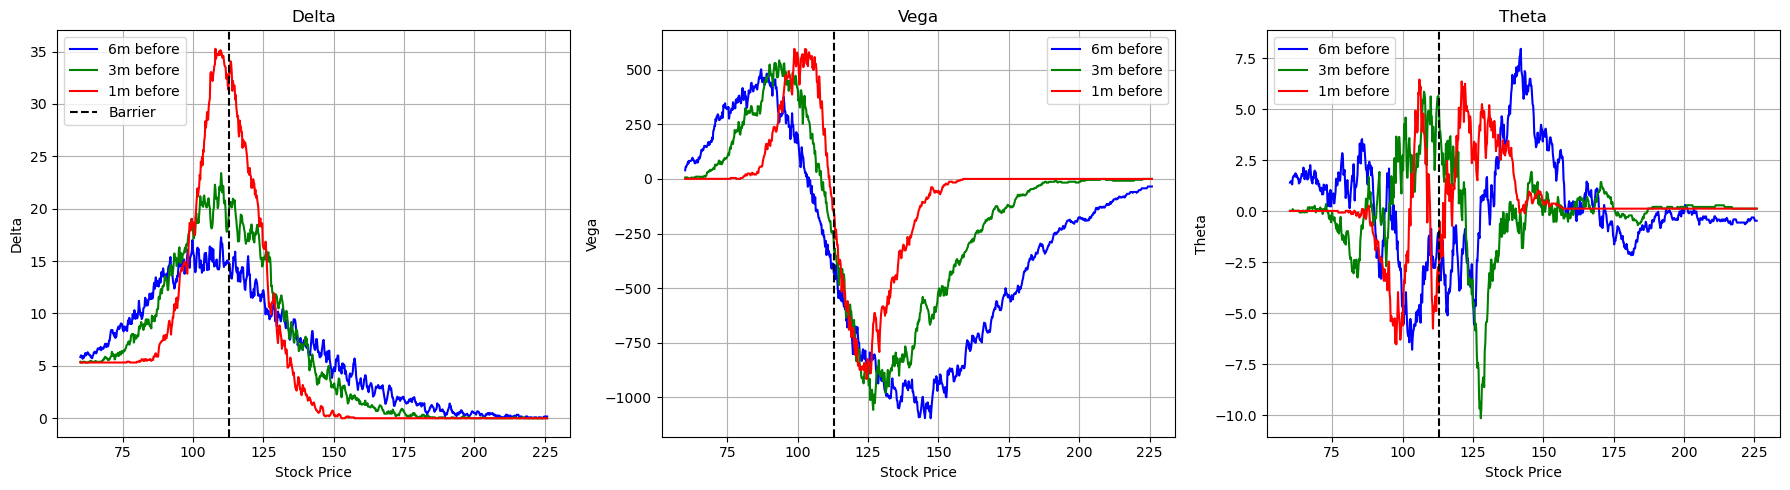

In [10]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# --- Plot Greeks: 1x3 layout ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
colors = ['blue', 'green', 'red']

# --- Delta ---
axs[0].set_title("Delta")
for i, col in enumerate(delta_matrix.columns):
    axs[0].plot(price_range, delta_matrix[col], color=colors[i], label=col)
axs[0].axvline(barrier, linestyle='--', color='black', label="Barrier")
axs[0].set_xlabel("Stock Price")
axs[0].set_ylabel("Delta")
axs[0].grid(True)
axs[0].legend(loc='upper left')

# --- Vega ---
axs[1].set_title("Vega")
for i, col in enumerate(vega_matrix.columns):
    axs[1].plot(price_range, vega_matrix[col], color=colors[i], label=col)
axs[1].axvline(barrier, linestyle='--', color='black')
axs[1].set_xlabel("Stock Price")
axs[1].set_ylabel("Vega")
axs[1].grid(True)
axs[1].legend(loc='upper right')

# --- Theta ---
axs[2].set_title("Theta")
for i, col in enumerate(theta_matrix.columns):
    axs[2].plot(price_range, theta_matrix[col], color=colors[i], label=col)
axs[2].axvline(barrier, linestyle='--', color='black')
axs[2].set_xlabel("Stock Price")
axs[2].set_ylabel("Theta")
axs[2].grid(True)
axs[2].legend(loc='upper left')

plt.tight_layout()
#plt.savefig("greeks_plot_reduced.pdf", format="pdf")
plt.show()